# 9. Houghova transformácia

In [136]:
import numpy as np
from matplotlib import cm
from skimage import data, filters, draw, feature, img_as_ubyte
import matplotlib.pyplot as plt
from IPython.display import display
import matplotlib.lines as lines
from scipy.signal import find_peaks
from skimage.color import rgb2gray, gray2rgb
from skimage.draw import circle_perimeter
from skimage.transform import hough_line, probabilistic_hough_line, hough_circle, hough_circle_peaks

In [137]:
plt.rcParams['text.color'] = 'w'
plt.rcParams['xtick.color'] = 'w'
plt.rcParams['ytick.color'] = 'w'
plt.rcParams['axes.labelcolor'] = 'w'
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

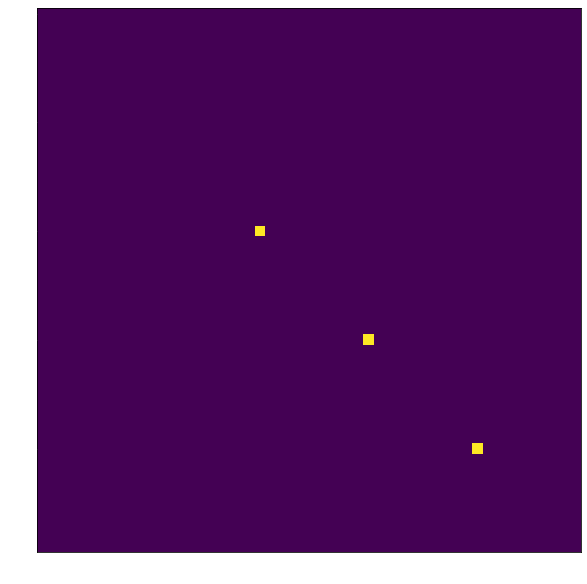

In [138]:
I = np.zeros((50,50))
I[20,20]=1
I[30,30]=1
I[40,40]=1
plt.figure(figsize=(15,10))
plt.imshow(I)

## rho= x * cos(theta) + y * sin(theta)

In [139]:
thetas = np.arange(0, np.pi, 0.02)
display("Theta has: "+ str(thetas.size)+" values.")

'Theta has: 158 values.'

Text(0, 0.5, 'Rhos - posunutie ak chcem trafit hranu')

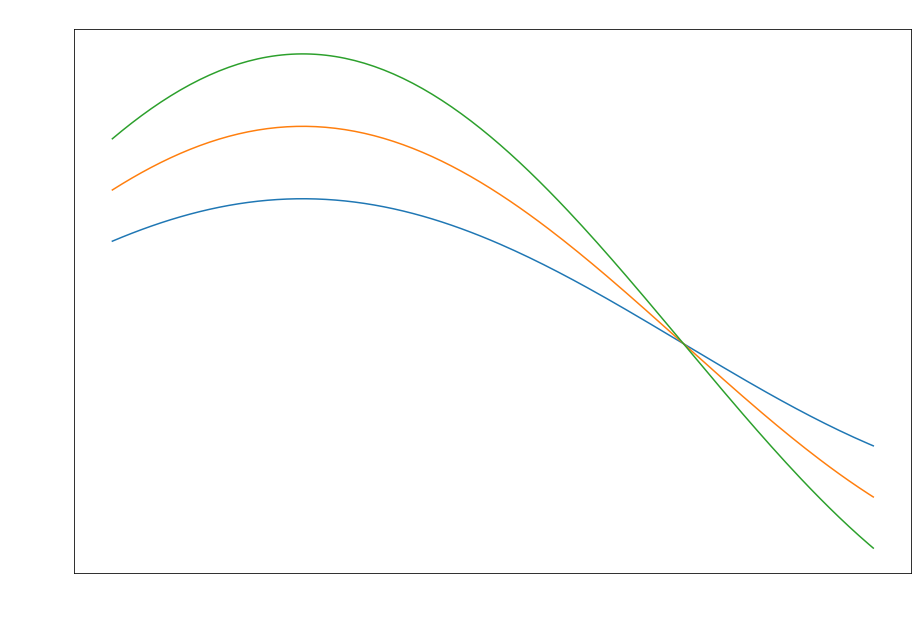

In [140]:
x,y = np.where(I==1)
plt.figure(figsize=(15,10))
rho_stack = []
for i in range(0,x.size):
    rhos = x[i] *np.cos(thetas) + y[i]* np.sin(thetas)
    rho_stack.append(rhos)
    plt.plot(np.rad2deg(thetas), rhos)
plt.title("Houghov priestor parametrov Rho a Theta")
plt.xlabel("Theta - uhol v stupnoch")
plt.ylabel("Rhos - posunutie ak chcem trafit hranu")

In [141]:
rho_stack = np.array(rho_stack)

r1 = np.abs(rho_stack[0,:]-rho_stack[1,:])
r2 = np.abs(rho_stack[0,:]-rho_stack[2,:])
r3 = np.abs(rho_stack[1,:]-rho_stack[2,:])

min_dif = np.where((r1+r2+r3) == np.min(r1+r2+r3) )
rho_winner = rho_stack[0,min_dif]
theta_winner = thetas[min_dif]
display("We found fitting  line with params Rho: {} pixels and Theta {} degrees".format(rho_winner,np.rad2deg(theta_winner)))


'We found fitting  line with params Rho: [[-0.10763581]] pixels and Theta [135.21803965] degrees'

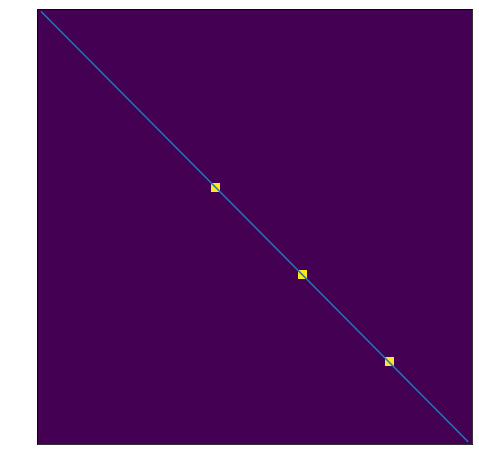

In [142]:
line_x = np.array([[0, I.shape[1]-1]])
line_y = (-np.cos(theta_winner)/np.sin(theta_winner))*line_x + rho_winner/np.sin(theta_winner)
plt.figure(figsize=(8,8))
plt.imshow(I)
plt.plot(line_x.ravel(),line_y.ravel())

In [143]:
accumulator = []
for i in range(0,x.size):
    rhos = x[i] *np.cos(thetas) + y[i]* np.sin(thetas)
    accumulator.append(rhos)
accumulator = np.array(rho_stack)

D = np.sqrt(I.shape[0]**2+ I.shape[1]**2) #uhlopriecka
rho_range =np.arange(-I.shape[1],D,1)   # ake realne hodnoty moze naberat priamka v obraze?

In [144]:
hough_space = np.zeros((rho_range.size, thetas.size))

### Akumulacia do disktretizovanej matice (obrazka *)

Text(0, 0.5, 'Rhos - premapovane do disk. priestoru <0,121)')

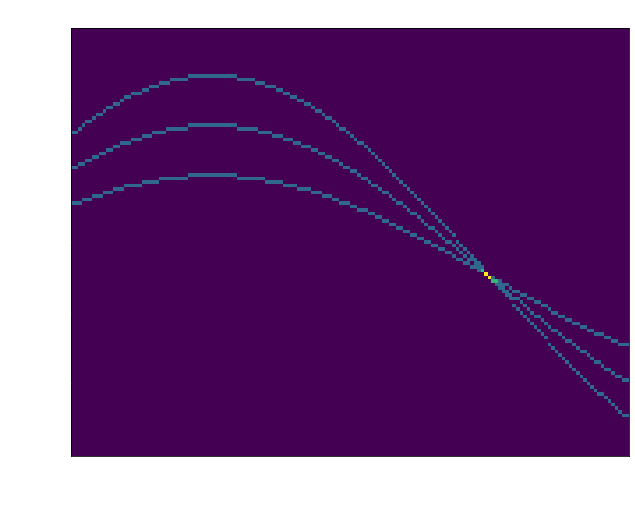

In [145]:
for i in range(0,thetas.size):
    rho_vals = accumulator[:,i]
    y_hist, x_hist = np.histogram(rho_vals, rho_range)
    hough_space[:hough_space.shape[0]-1, i] = np.flipud(y_hist)
plt.figure(figsize=(10,10))
plt.imshow(hough_space)

plt.title("Houghov priestor parametrov Rho a Theta")
plt.xlabel("Theta - premapovane do disk. priestoru <0,158)")
plt.ylabel("Rhos - premapovane do disk. priestoru <0,121)")

In [146]:
max_hough = np.max(hough_space)
x, y = np.where(hough_space == max_hough)
theta_winner= thetas[y[1]]
rho_winner = rho_range[rho_range.size - x[1]]

display("We found fitting  line with params Rho: {} pixels and Theta {} degrees".format([rho_winner],np.rad2deg(theta_winner)))

'We found fitting  line with params Rho: [1.0] pixels and Theta 135.2180396508743 degrees'

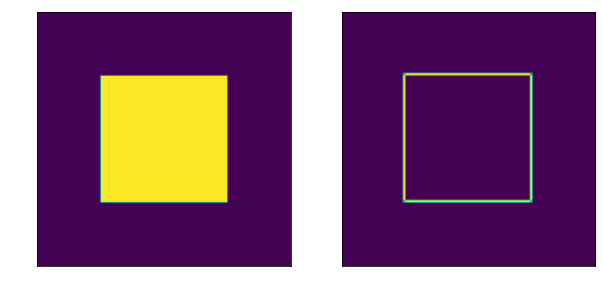

In [147]:
plt.figure(figsize=(10,10))
I = np.zeros((100, 100))
I[25:75,25:75] = 255
plt.subplot(121)
plt.imshow(I)
I = filters.roberts(I)
plt.subplot(122)
plt.imshow(I)

In [148]:
width, height = I.shape
D = (height**2 + width**2)**(1/2)

thetas = np.arange(0,np.pi,0.01)
rhos = np.arange(-width,D,1)

hough_space = np.zeros((rhos.size, thetas.size))

In [149]:
x, y = np.where(I > 0)

In [150]:
accumulator = np.zeros((x.size, thetas.size))

cos_vals = np.matmul(np.expand_dims(np.arange(0,width,1),axis=0).T,
                     np.expand_dims(np.cos(thetas),axis=0))
sin_vals = np.matmul(np.expand_dims(np.arange(0,height,1),axis=0).T,
                     np.expand_dims(np.sin(thetas),axis=0))

In [151]:
x_match = cos_vals[x,:]
y_match = sin_vals[y,:]
accumulator[:,:] =  x_match + y_match

for i in range(0,thetas.size):
    rho_vals = accumulator[:,i]
    y_hist, x_hist = np.histogram(rho_vals, rhos)
    hough_space[1:,i] = np.flipud(y_hist)

Text(0, 0.5, 'Rhos')

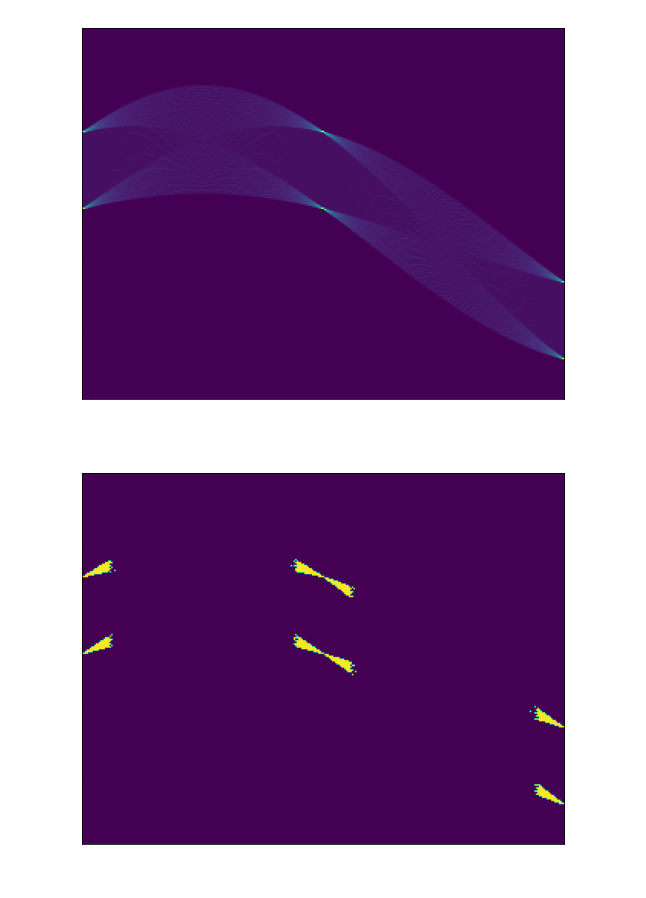

In [152]:
plt.figure(figsize=(25,15))
plt.subplot(211)
plt.imshow(hough_space)
plt.title("Houghov priestor parametrov Rho a Theta")
plt.xlabel("Theta")
plt.ylabel("Rhos")
plt.subplot(212)
plt.imshow(hough_space> np.percentile(hough_space,99))
plt.title("Houghov priestor parametrov Rho a Theta 99th percentile")
plt.xlabel("Theta")
plt.ylabel("Rhos")

In [153]:
thresh = 0.5*np.max(hough_space[:])
supp = 15
continue_search = 1
peaks = []

[[67, 0], [67, 156], [117, 0], [117, 156], [165, 313], [215, 313]]


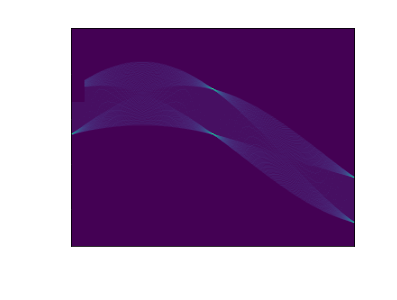

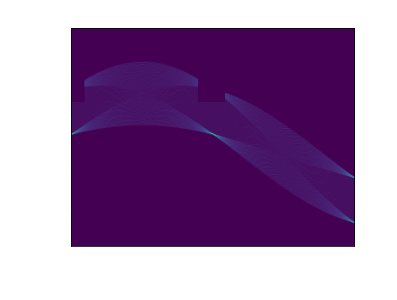

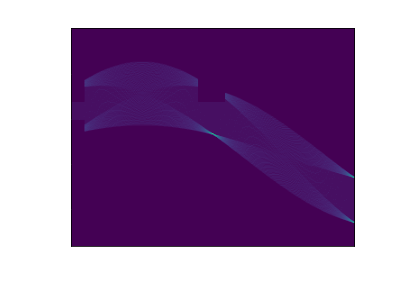

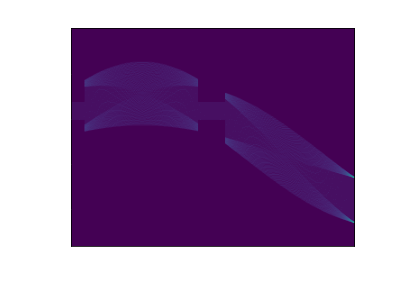

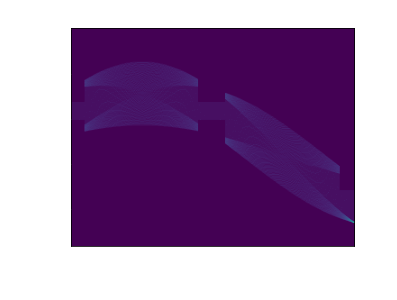

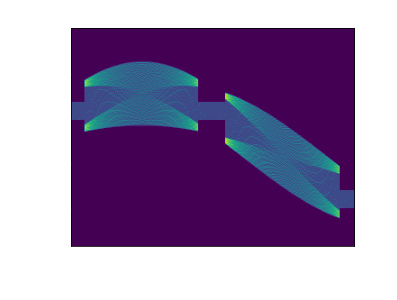

<Figure size 432x288 with 0 Axes>

In [154]:
while continue_search == 1:
    value = np.max(hough_space[:])

    if value>thresh:
        index = np.where(hough_space[:] == value)
        index_rho, index_theta= index[0][0], index[1][0]
        peaks.append([(index_rho), (index_theta)])
        x_min = index_rho - supp
        if x_min < 0:
            x_min = 0
        x_max = index_rho + supp
        if x_max > hough_space.shape[0]:
            x_max = hough_space.shape[0]
        y_min = index_theta - supp
        if y_min < 0:
            y_min = 0
        y_max = index_theta + supp
        if y_max > hough_space.shape[1]:
            y_max=hough_space.shape[1]

        hough_space[x_min:x_max,y_min:y_max] = 0
        plt.imshow(hough_space)
        plt.title("Houghov priestor, prehladavanie")
        plt.xlabel("Theta (radiany)")
        plt.ylabel("Rhos (pixely)")
        plt.figure()

    else:
        continue_search = 0


print(peaks)

<ipython-input-155-b7bcdf700a30>:10: RuntimeWarning: divide by zero encountered in double_scalars
  line_y = (-np.cos(theta)/np.sin(theta))*line_x + rho/np.sin(theta)
<ipython-input-155-b7bcdf700a30>:10: RuntimeWarning: invalid value encountered in multiply
  line_y = (-np.cos(theta)/np.sin(theta))*line_x + rho/np.sin(theta)
<ipython-input-155-b7bcdf700a30>:10: RuntimeWarning: invalid value encountered in add
  line_y = (-np.cos(theta)/np.sin(theta))*line_x + rho/np.sin(theta)
<ipython-input-155-b7bcdf700a30>:14: RuntimeWarning: divide by zero encountered in double_scalars
  line_x = (line_y - rho/np.sin(theta))*(np.sin(theta)/np.cos(theta))
<ipython-input-155-b7bcdf700a30>:14: RuntimeWarning: invalid value encountered in multiply
  line_x = (line_y - rho/np.sin(theta))*(np.sin(theta)/np.cos(theta))


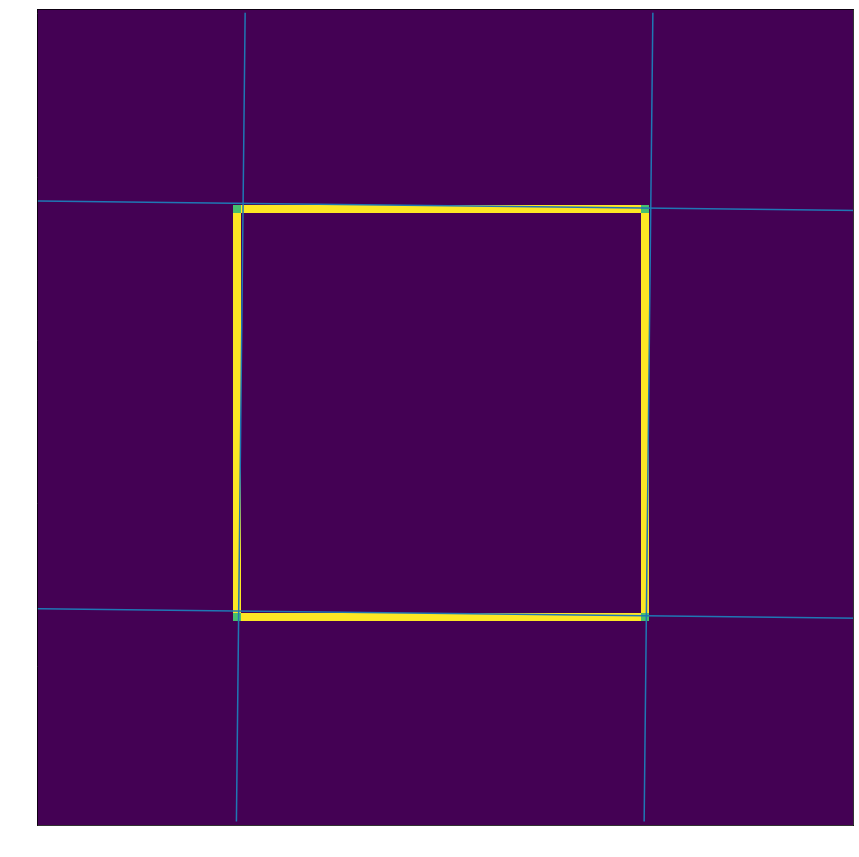

In [155]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
ax.imshow(I)

for peak in peaks:
    theta = thetas[peak[1]]
    rho = rhos[rhos.size - peak[0]]

    line_x = np.array([[0, I.shape[1]-1]])
    line_y = (-np.cos(theta)/np.sin(theta))*line_x + rho/np.sin(theta)

    if np.sum(np.isnan(line_y)) > 0:
        line_y = np.array([[0, I.shape[0]-1]])
        line_x = (line_y - rho/np.sin(theta))*(np.sin(theta)/np.cos(theta))

    ax.add_line(lines.Line2D(line_y, line_x))

plt.show()

Text(0.5, 1.0, 'detekovane hrany')

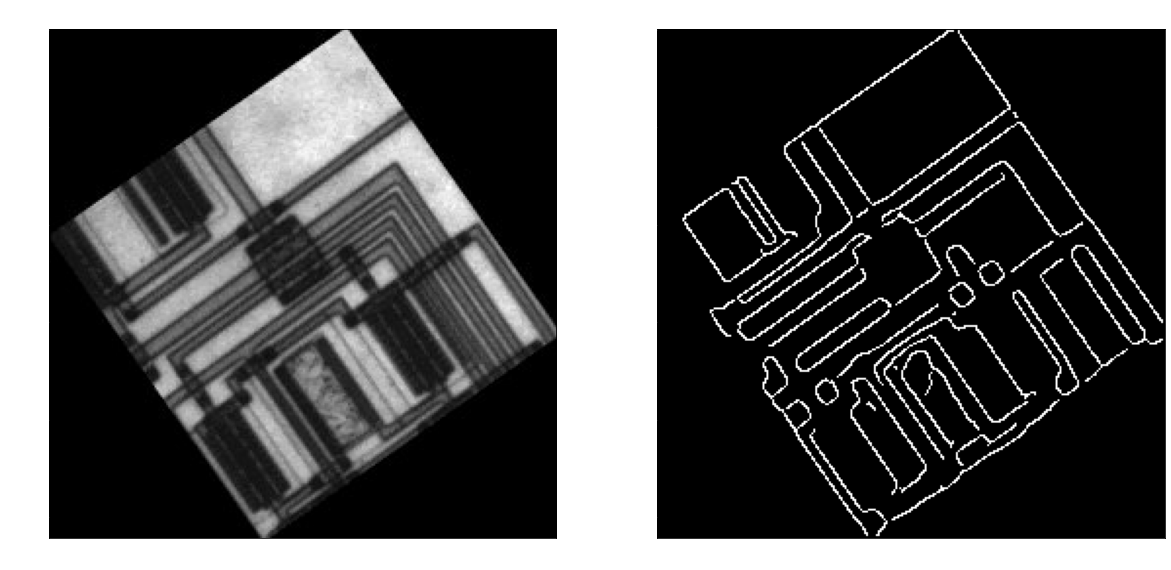

In [156]:
I = plt.imread('imgs/circuit.jpg')
I_gray = rgb2gray(I)

plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(I_gray, cmap='gray')
plt.title("Povodny obrazok")

plt.subplot(122)
BW = feature.canny(I_gray, sigma = 2)
plt.imshow(BW, cmap='gray')
plt.title("detekovane hrany")


<ipython-input-157-6780e8207a47>:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(T,R,H, cmap="jet", shading='flat')


Text(0.5, 1.0, 'Houghov priestor')

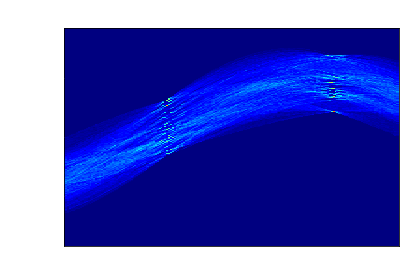

In [157]:
H, T, R = hough_line(BW)
plt.pcolor(T,R,H, cmap="jet", shading='flat')
plt.title('Houghov priestor')

In [158]:
#P = find_peaks(H, T)
#plt.imshow(P)

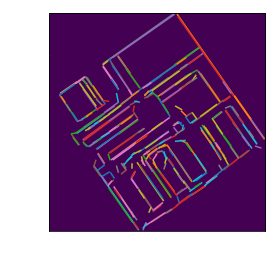

In [159]:
edges = feature.canny(I_gray, sigma=2)
lines = probabilistic_hough_line(edges, threshold=10, line_length=5,
                                 line_gap=3)

plt.imshow(edges * 0)
for line in lines:
    p0, p1 = line
    plt.plot((p0[0], p1[0]), (p0[1], p1[1]))


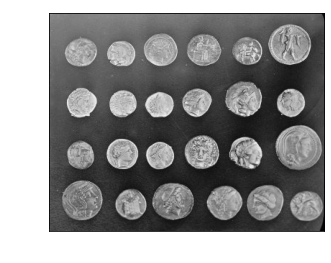

<Figure size 432x288 with 0 Axes>

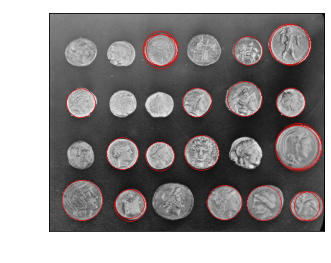

In [165]:
img = img_as_ubyte(data.coins())
plt.imshow(img, cmap="gray")
plt.figure()

edges = feature.canny(img, sigma=3, low_threshold=10, high_threshold=50)

hough_radii = np.arange(20, 35, 2)
hough_res = hough_circle(edges, hough_radii)

accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii, total_num_peaks=24)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
img2 = gray2rgb(img)
for center_y, center_x, radius in zip(cy, cx, radii):
    circy, circx = circle_perimeter(center_y, center_x, radius,
                                    shape=img2.shape)
    img2[circy, circx] = (220, 20, 20)

ax.imshow(img2, cmap="gray")
plt.show()